### parallel contributions

In [ ]:
!pip install -r requirements.txt

In [11]:
from end_to_end import run_end_to_end
import tensorflow as tf

# set tensorflow random seed to make outputs reproducible
tf.random.set_seed(123)

The cell below recreates the results in the 'outputs' folder:

In [12]:
from utils import prepare_data, noise, display
from initial_model import create_autoencoder
from initial_tests import check_initial_recall, iterative_recall
from generative_model import build_encoder_decoder_v1, VAE,build_encoder_decoder_v2, build_encoder_decoder_v3, build_encoder_decoder_v4, build_encoder_decoder_v5
from generative_tests import interpolate_ims, plot_latent_space, check_generative_recall, plot_history, vector_arithmetic
from tensorflow import keras
import numpy as np
from random import randrange
from PIL import Image
import matplotlib.pyplot as plt
import hopfield_utils
from hopfield_models import ContinuousHopfield
import matplotlib.backends.backend_pdf
from config import models_dict, dims_dict


def run_end_to_end(initial='autoencoder', generative='vae', dataset='mnist', initial_epochs=10, generative_epochs=10, num=100, latent_dim=5, kl_weighting=1, hopfield_type='continuous', lr=0.001):
    
    pdf = matplotlib.backends.backend_pdf.PdfPages("./outputs/output_{}_{}items_{}_{}eps_{}_{}eps_{}lv_{}lr_{}kl.pdf".format(dataset, num, initial, initial_epochs, generative, generative_epochs, latent_dim, lr, kl_weighting))
    
    train_data, test_data, noisy_train_data, noisy_test_data = prepare_data(dataset)
    
    dims = dims_dict[dataset]
    model = models_dict[dataset]
        
    if initial == 'hopfield':
        net = hopfield_utils.create_hopfield(num, hopfield_type=hopfield_type, dataset=dataset)
        predictions = []
        tests = []
        
        images = hopfield_utils.load_images_mnist(num, dataset=dataset)

        images_np = hopfield_utils.convert_images(images, 'gray-scale')
        images_masked_np = hopfield_utils.mask_image_random(images_np)
        images_np = [im_np.reshape(-1, 1) for im_np in images_np]
        images_masked_np = [im_np.reshape(-1, 1) for im_np in images_masked_np]
        
        for test_ind in range(num):
            test = images_masked_np[test_ind].reshape(-1,1)
            if hopfield_type is 'classical':
                reconstructed = net.retrieve(test)
            else:
                reconstructed = net.retrieve(test, max_iter=10)
            # if your image is greyscale, you need to pass PIL 2d array
            reshaped = np.array(reconstructed).reshape(1,dims[0],dims[1])
            test = np.array(test).reshape(1,dims[0],dims[1])
            predictions.append(reshaped.reshape(1,dims[0],dims[1],dims[2]))
            tests.append(test.reshape(1,dims[0],dims[1],dims[2]))
            
        print("Recalling noisy images with the initial model:")
        predictions = np.concatenate(predictions, axis=0)
        tests = np.concatenate(tests, axis=0)
        
        fig = display(tests,predictions, dataset=dataset, title='Inputs and outputs for Hopfield network')
        pdf.savefig(fig)
        # rescale predictions back to interval [0, 1]
        predictions = (predictions + 1) / 2 

    else:
        print("Initial model not supported.")
        
    if generative == 'vae':    
        
        encoder, decoder = models_dict[dataset](latent_dim = latent_dim)
        vae = VAE(encoder, decoder, kl_weighting)
        opt = keras.optimizers.Adam(lr=lr)
        vae.compile(optimizer=opt)
        history = vae.fit(predictions, epochs=generative_epochs, verbose=0, batch_size=32, shuffle=True)
    
        fig = plot_history(history)
        pdf.savefig(fig)
        
        print("Recalling noisy images with the generative model:")
        fig = check_generative_recall(vae, train_data[0:100])
        pdf.savefig(fig)
        
        print("Interpolating between image pairs:")
        latents = vae.encoder.predict(test_data)
        for i in range(10):
            fig = interpolate_ims(latents, vae, randrange(50), randrange(50))
            pdf.savefig(fig)
            
        for i in range(10):
            fig = vector_arithmetic(latents, vae, randrange(50), randrange(50), randrange(50))
            pdf.savefig(fig)
        
    else:
        print("Generative model not supported.")
        
    pdf.close()
    return net, vae
        
    

Recalling noisy images with the initial model:


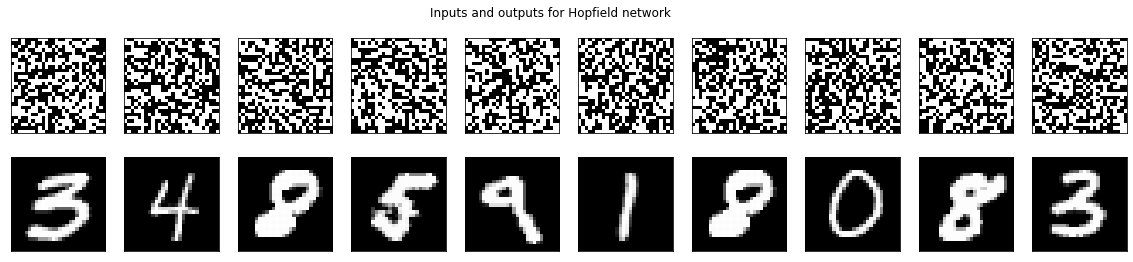

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: UserWarning: Casting input data from 'float128' to 'float64' for imshow


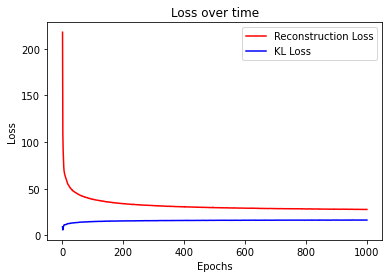

Recalling noisy images with the generative model:


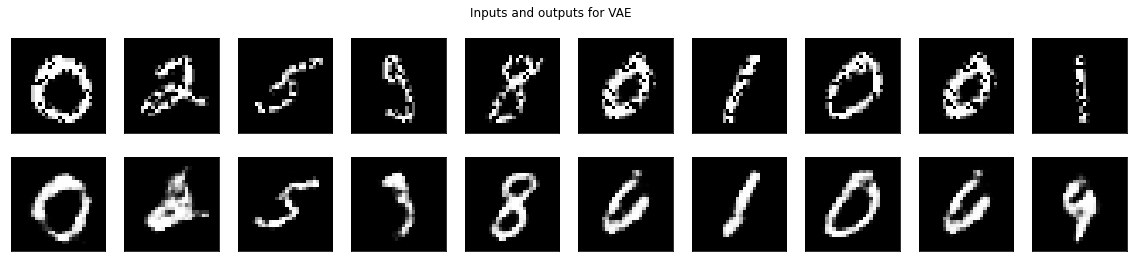

Interpolating between image pairs:


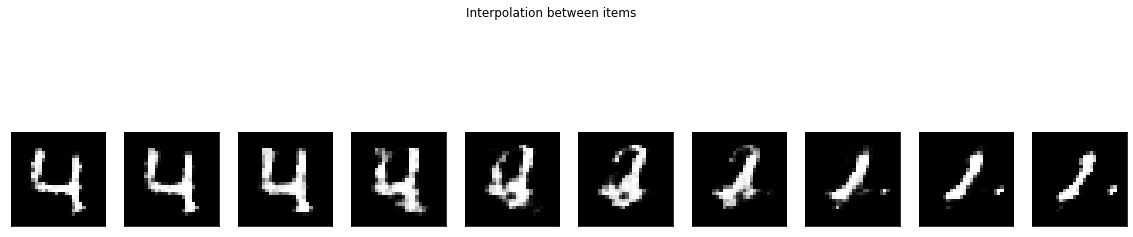

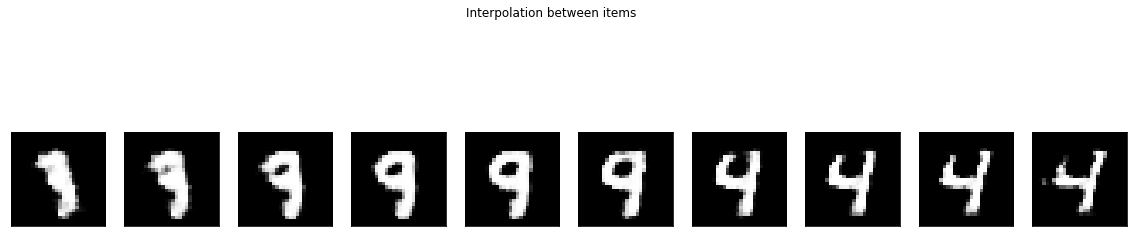

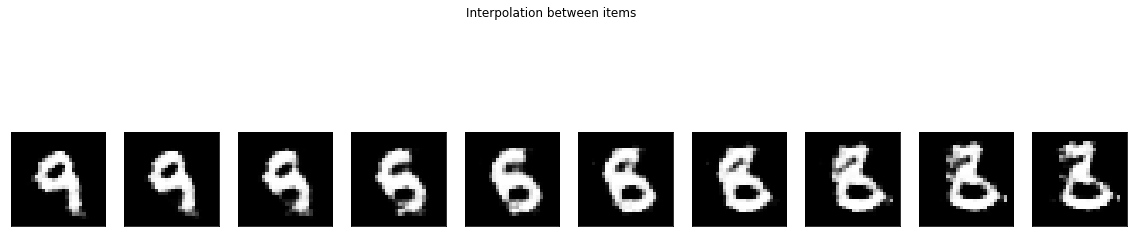

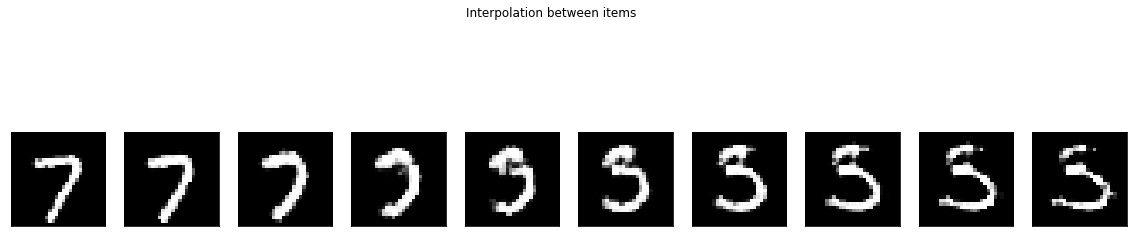

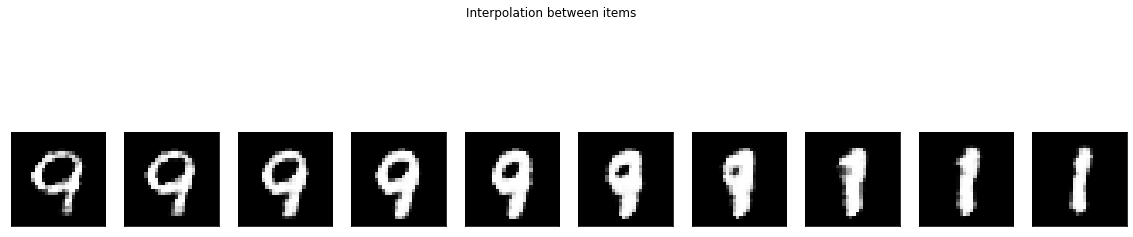

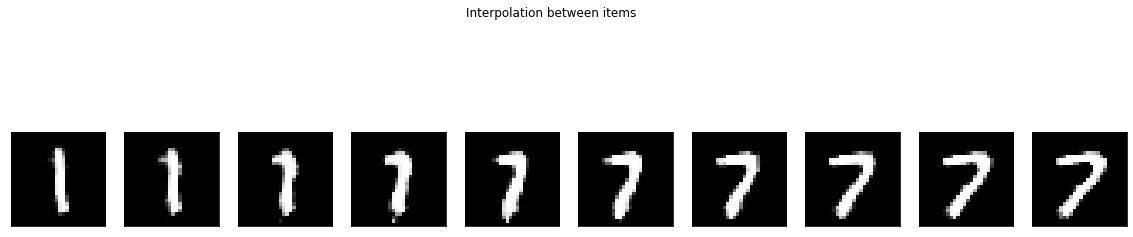

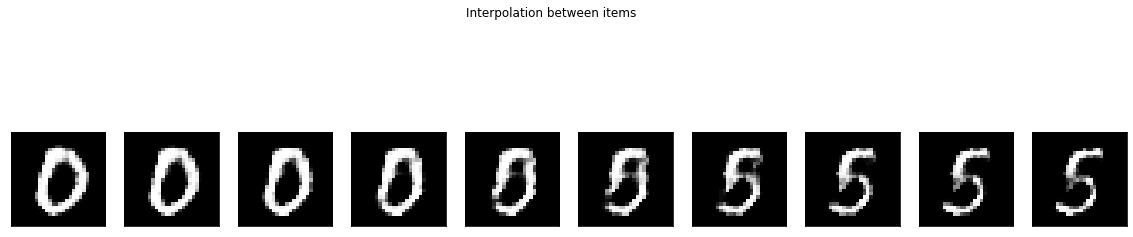

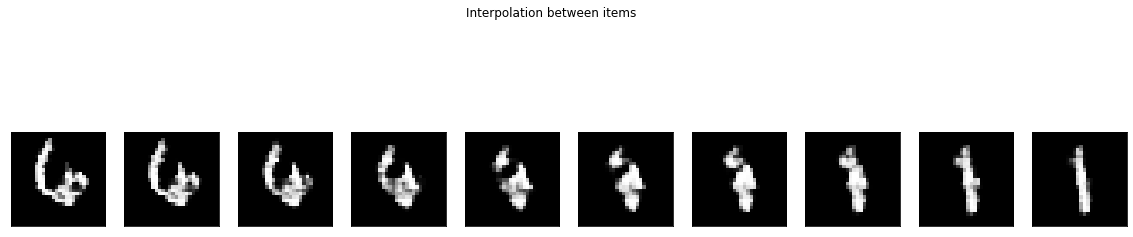

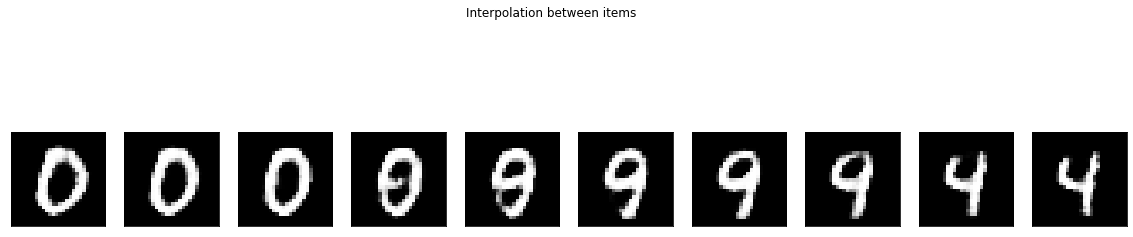

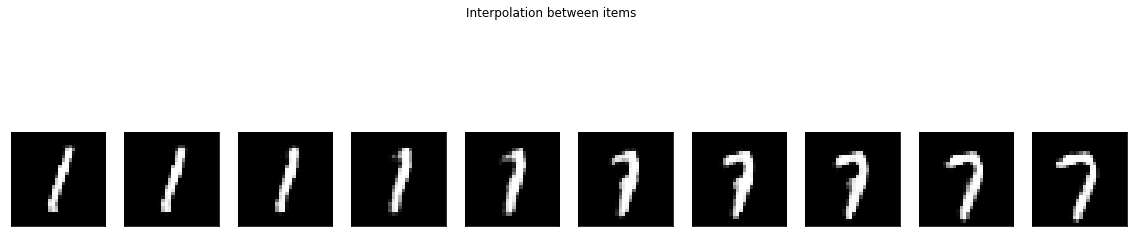

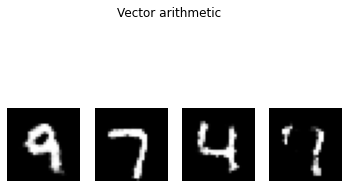

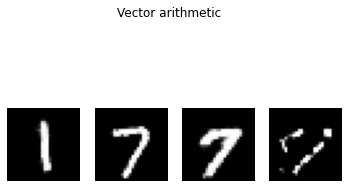

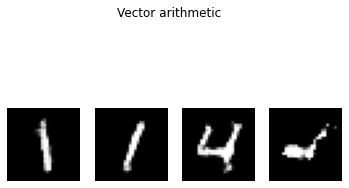

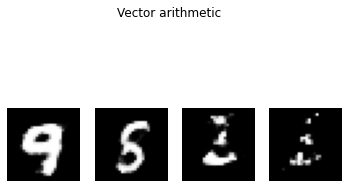

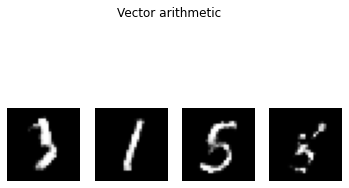

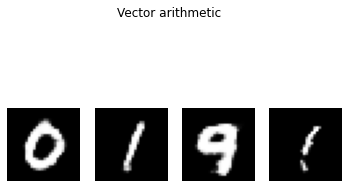

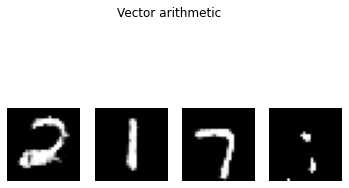

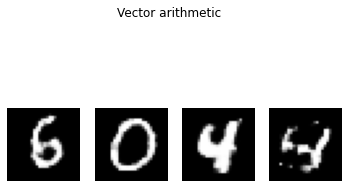

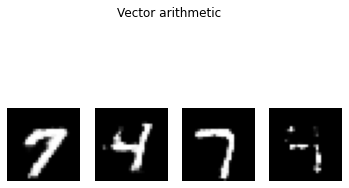

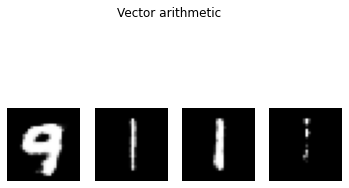

In [13]:
net, vae = run_end_to_end(initial='hopfield', generative='vae', dataset='mnist', generative_epochs=1000, 
               num=3000, latent_dim=10, kl_weighting=1)

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from utils import display, noise
from math import sqrt

def check_generative_recall(vae, test_data, noise_level=0.25):
    test_data = noise(test_data, noise_factor=noise_level)
    latents = vae.encoder.predict(test_data)
    predictions = vae.decoder.predict(latents[0])
    fig = display(test_data, predictions, title='Inputs and outputs for VAE')
    return predictions

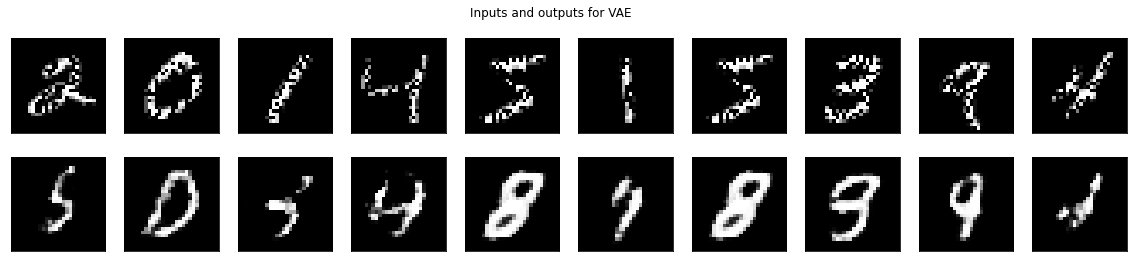

In [15]:
train_data, test_data, noisy_train_data, noisy_test_data = prepare_data('mnist')
preds = check_generative_recall(vae, train_data[0:10], noise_level=0.4)

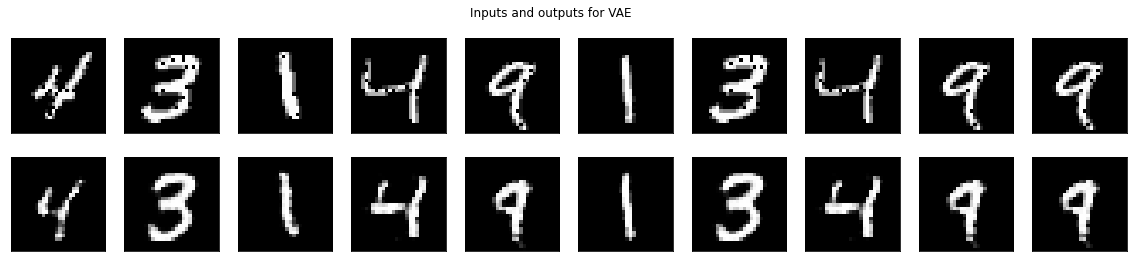

In [16]:
train_data, test_data, noisy_train_data, noisy_test_data = prepare_data('mnist')
preds = check_generative_recall(vae, train_data[0:10], noise_level=0.1)

In [17]:

def display(array1, array2, seed=None, title='Inputs and outputs of the model', dataset='mnist'):
    hopfield=False
    
    dim = array1[0].shape[0]
    #Displays ten random images from each one of the supplied arrays.
    if seed is not None:
        np.random.seed(seed)
        
    n = 10

    images1 = array1
    images2 = array2

    fig = plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        if hopfield==True:
            plt.imshow(image1.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image1.reshape(dim, dim))
            plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        if hopfield==True:
            plt.imshow(image2.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image2.reshape(dim, dim))
            plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig.suptitle(title)
    plt.show()
    return fig


Recalling noisy images with the initial model:


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


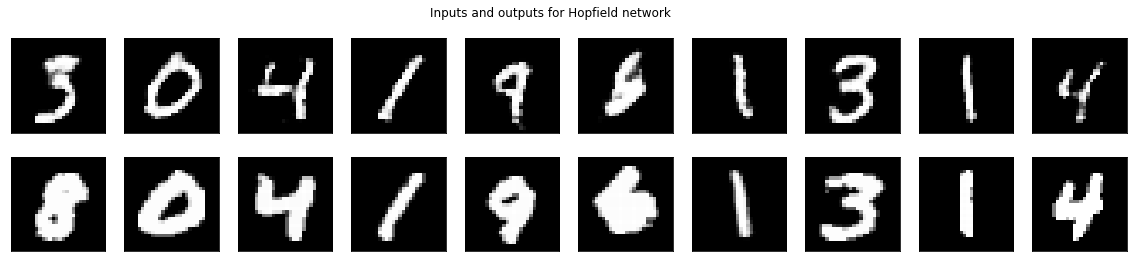

In [18]:
num = 10
dims=(28,28,1)

predictions = []
tests = []

for test_ind in range(num):
    test = preds[test_ind].reshape(-1,1)
    reconstructed = net.retrieve(test, max_iter=10)
    # if your image is greyscale, you need to pass PIL 2d array
    reshaped = np.array(reconstructed).reshape(1,dims[0],dims[1])
    test = np.array(test).reshape(1,dims[0],dims[1])
    predictions.append(reshaped.reshape(1,dims[0],dims[1],dims[2]))
    tests.append(test.reshape(1,dims[0],dims[1],dims[2]))

print("Recalling noisy images with the initial model:")
predictions = np.concatenate(predictions, axis=0)
tests = np.concatenate(tests, axis=0)

fig = display(tests,predictions, dataset='mnist', title='Inputs and outputs for Hopfield network')
        